In [1]:
## code was written using Python 2.7.13 ##
import numpy as np #v1.14.4
import seaborn as sns #v0.7.1
import matplotlib as plt #v1.5.1
import matplotlib.pyplot as plt
%matplotlib inline
import scipy as sc #v0.19.0
from scipy import stats
import sklearn #0.18.1
from sklearn import svm
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
import pandas as pd #0.23.0
import os
import csv
import warnings
warnings.filterwarnings('ignore')

In [98]:
##EDIT THIS SECTION##

## open multiple files called 'extractedsignals.npy' and combine into single array.
## the best way to do this is to point the basedir to a folder. Within that folder there are multiple folders (named to identify
## session,mouse,FOV,etc), which each contain EXACTLY 1 file called EXACTLY 'extractedsignals.npy'

%cd 'C:\Users\Stuber Lab\Desktop\Raw data\obesity imaging'  ##point to data location ##

maxnumneurons = 1000 #just used to initialize arrays. Should be larger than the total number of neurons
maxframes=3000       #number of frames

## Do you want to use F/F0 or z-scored data?
use_raw_data=['yes'] ## if 'no' then data will be z-scored
raw_threshold=1.1  #define raw threshold value for identifying events
z_threshold=1.5      #define z threshold value for identifying events

framerate=5 #framerate in Hz

### Filter the event by duration or area under the curve (values of 0 = unfiltered)
timethreshold=2  #threshold for duration of event (in seconds) 
areathreshold=0  #threshold for area under the curve of event

#do you want to use the low-pass filter to adjust the z-score values?
low_pass_filter_on=['no'] #either 'yes' or 'no'
lowpass_filter=1.1 # Change this to modify the low-pass correction. (values between 1.05 and 1.1 usually work well)

#do you want to PLOT all individual traces? (if you have a lot of cells, this can be pretty time consuming)
plot_traces=['no'] ##plot unfiltered traces?
plot_traces_filtered=['no'] ##plot filtered traces?

#do you want to EXPORT individual traces? plot_traces must equal 'yes' in order to export traces.
export_traces=['no']

# do you want to export data files?
export_files=['no']

## do you want to save bar graphs?
save_figs=['no']

## if you want to limit your analysis to a certain range of frames, change start_frame and end_frame below
start_frame=0 
end_frame=3000

bin_avg=3 #rolling average smooth; greater values increase the smoothing

C:\Users\Stuber Lab\Desktop\Raw data\obesity imaging


In [99]:
def find_events(basedir,filename):
    signals_pop = np.nan*np.zeros((maxnumneurons,maxframes))
    data_dirs = os.walk(basedir).next()[1]
    numneuronstillnow = 0
    for data_dir in data_dirs:
        signals=np.load(os.path.join(basedir,data_dir,'extractedsignals.npy'))
        numneurons=signals.shape[1]
        numframes=signals.shape[2]
        temp_signals=np.squeeze(signals)
        for a in range(0,numneurons):
            signals_pop[numneuronstillnow+a,:numframes]=temp_signals[a,:]
        numneuronstillnow += numneurons
    extractedsignals=signals_pop[:numneuronstillnow,:numframes]
    print ' '
    print filename
    print 'files = '+str(data_dirs)

    ## if you want to limit your analysis to a certain range of ROIs, change start_roi and end_roi below
    start_roi=0
    end_roi=extractedsignals.shape[0]

    #save parameters to csv
    params=['framerate = '+str(framerate),'z-threshold = '+str(z_threshold),'raw threshold = '+str(raw_threshold),
            'time threshold = '+str(timethreshold),
             'area threshold = '+str(areathreshold),'low pass filter on? = '+low_pass_filter_on[0],
             'low pass filter = '+str(lowpass_filter),'start frame = '+str(start_frame),'end frame = '+str(end_frame),
             'number of cells = '+str(extractedsignals.shape[0]), 'use raw data? = '+str(use_raw_data[0])]
    with open(filename+'_parameters','wb') as myfile:
        out=csv.writer(myfile,delimiter=',')
        out.writerow(params)

    #zscore data
    zscore_signals=stats.zscore(extractedsignals[:,:], axis=1)
    numrois=zscore_signals.shape[0]
    numframes=zscore_signals.shape[1]
    if use_raw_data[0]=='yes':
        zscore_signals=extractedsignals
        y_axis='F/F0'
        threshold=raw_threshold
    else:
        y_axis='z-scored intensity'
        threshold=z_threshold
    print 'Total ROIs = '+str(numrois)
    print 'Total Frames = '+str(numframes)

    #restrict frames/ROIs to values defined above
    zscore_signals=zscore_signals[start_roi:end_roi,start_frame:end_frame]
    numrois=zscore_signals.shape[0]
    numframes=zscore_signals.shape[1]
    print 'ROIs after restriction = '+str(numrois)
    print 'Frames after restriction = '+str(numframes)

    ##re-zscore data after removing high-amplitude events
    ## Correction is as follows:
    ## 1.    Lowpass filter Raw SIMA traces
    ## 2.    (Mean(raw) - Mean(filt)) / STD(raw) = Correction Constant
    ## 3.    Zscore (raw) - Correction Constant = Corrected z-score
    zscore_signals_filt=np.nan*np.empty(zscore_signals.shape)
    for a in range(0,zscore_signals.shape[0]):
        for b in range(0,zscore_signals.shape[1]):
            if extractedsignals[a,b]>lowpass_filter:
                zscore_signals_filt[a,b]=np.nan
            else:
                zscore_signals_filt[a,b]=extractedsignals[a,b]
    zscore_signals_filt_mean=np.nanmean(zscore_signals_filt, axis=1)
    zscore_signals_mean=np.nanmean(extractedsignals, axis=1)  
    adjust_zscore=zscore_signals_filt_mean-zscore_signals_mean
    extractedsignals_std=np.nanstd(extractedsignals, axis=1)
    zscore_signals_filt_mean=np.nanmean(zscore_signals_filt, axis=1)
    zscore_signals_filt_std=np.nanstd(extractedsignals, axis=1)
    for a in range(0,zscore_signals.shape[0]):
        for b in range(0,zscore_signals.shape[1]):
            zscore_signals_filt[a,b]=(zscore_signals_filt[a,b]-zscore_signals_filt_mean[a])/(zscore_signals_filt_std[a])      
    for a in range(0,zscore_signals.shape[0]):
        for b in range(0,zscore_signals.shape[1]):
            zscore_signals_filt[a,b]=zscore_signals[a,b]-(adjust_zscore[a]/extractedsignals_std[a])

    ##low pass filter##
    if low_pass_filter_on[0]=='yes':
        zscore_signals=zscore_signals_filt  
    else:
        zscore_signals=zscore_signals
    print 'low-pass filter = '+low_pass_filter_on[0]

    ## rolling mean smooth on the zscored data.##
    zscore_signals_df=pd.DataFrame(zscore_signals[:,:])
#     signals_smoothed=pd.rolling_mean(zscore_signals_df, bin_avg, axis=1) #used for older versions of Pandas
    signals_smoothed=zscore_signals_df.rolling(bin_avg,axis=1).mean()
    signals_smoothed=pd.DataFrame.as_matrix(signals_smoothed)
    signals_smoothed.shape

    #### find 'up' and 'down' events.  up corresponds to rising edge
    up=np.empty(signals_smoothed.shape)
    up[:]=np.NAN
    down=np.empty(signals_smoothed.shape)
    down[:]=np.NAN
    for a in range(0,numrois):
        for i in range(1,numframes-1):
            up[a,i]=signals_smoothed[a,i]>threshold and signals_smoothed[a,i-1]<threshold and signals_smoothed[a,i+1]>threshold
            down[a,i]=signals_smoothed[a,i]>threshold and signals_smoothed[a,i-1]>threshold and signals_smoothed[a,i+1]<threshold

    #plot ts with unfiltered event borders overlayed in red and export if desired
    if plot_traces[0]=='yes':
        uptimesthreshold=up*threshold
        downtimesthreshold=down*threshold
        uptimesthreshold[uptimesthreshold==0]=np.nan
        downtimesthreshold[downtimesthreshold==0]=np.nan    
        for a in range(0,numrois):
            fig,ax = plt.subplots(1)
            sns.tsplot(signals_smoothed[a,start_frame:end_frame])
            sns.tsplot(downtimesthreshold[a,start_frame:end_frame], c='r', interpolate=False)
            sns.tsplot(uptimesthreshold[a,start_frame:end_frame], c='c', interpolate=False)
            plt.xlabel('Frames', fontsize='16')
            plt.ylabel(y_axis, fontsize='16')
            plt.title('ROI numer '+str(a), fontsize='16')
            ax.set_axis_bgcolor('white')
            plt.show()
            if export_traces[0]=='yes':
                fig.savefig(filename+'_ROI_'+str(a)+'.png', format='png') #uncomment this line to save all traces
                fig.clf()

    #Remove event if trace starts or ends in 'up' state
    #if first nonzero element of combined is -1, then change it to 0, if the last nonzero is 1, make it zero
    down=down*-1
    combined=up+down #values of 1 indicates rise and -1 indicates fall
    for a in range(0,numrois):
        firstup=np.nanargmax(combined[a,:])
        firstdown=np.nanargmin(combined[a,:])
        if firstdown<firstup:
            combined[a,firstdown]=0     
    flipped=np.fliplr(combined)
    for a in range(0,numrois):
        lastup=np.nanargmax(flipped[a,:])
        lastdown=np.nanargmin(flipped[a,:])
        if lastup<lastdown:
            flipped[a,lastup]=0
    combined=np.fliplr(flipped)
    test=abs(combined)*threshold
    test[test==0]=np.nan

    #append frame number to array
    time=np.arange(numframes)
    zscore_signals2=np.squeeze(signals_smoothed)
    signals_with_time=np.vstack((zscore_signals2, time)) 
    signals_with_time[-1,:]
    #find frame number of 'up' and 'down' events.  Up corresponds to rising edge, down=falling edge
    diff_down=np.empty(signals_with_time.shape)
    diff_down[:]=np.NAN
    diff_up=np.empty(signals_with_time.shape)
    diff_up[:]=np.NAN
    for a in range(0,numrois):
        for i in range(0,numframes):
            if combined[a,i]<0:
                diff_down[a,i]=signals_with_time[-1,i]
            if combined[a,i]>0:
                diff_up[a,i]=signals_with_time[-1,i]             
    temp_up=np.empty([signals_with_time.shape[1],2])
    temp_up[:]=np.NAN
    temp_down=np.empty([signals_with_time.shape[1],2])
    temp_down[:]=np.NAN
    event_time=np.NAN*np.ones(signals_with_time.shape)
    allevents=np.NAN*np.ones(signals_with_time.shape)
    allareas=np.NAN*np.ones(signals_with_time.shape)
    allpeak=np.NAN*np.ones(signals_with_time.shape)
    
    maximum=np.nanmax(zscore_signals,axis=1)
    minimum=np.nanmin(zscore_signals,axis=1)
    std=np.nanstd(zscore_signals,axis=1)
    mean=np.nanmean(zscore_signals,axis=1)
    
    for a in range(0,numrois):
        temp_up[:,0]=diff_up[a,:]
        temp_down[:,1]=diff_down[a,:]
        temp_up2=temp_up[~np.isnan(temp_up)]
        temp_down2 = temp_down[~np.isnan(temp_down)]
        event_time=temp_down2-temp_up2
        for q in range (0,event_time.shape[0]):
            area=np.NAN*np.ones(event_time.shape[0])
            placehold_frames=signals_smoothed[a,int(temp_up2[q]):int(temp_down2[q])]
            peak=np.max(placehold_frames)
            area=np.trapz(placehold_frames)#, x=None, dx=1)#, axis=-1)   
            allareas[a,q] = area 
            allpeak[a,q] = peak
        allevents[a,:event_time.shape[0]] = event_time
    allevents=allevents/framerate
    allevents_pre_filt=allevents
    allareas_pre_filt=allareas
    framethreshold=timethreshold
    count_events=~np.isnan(allevents)
    count_events=np.sum(count_events,axis=1);count_events=count_events[0:count_events.shape[0]-1]
    event_dur_mean=np.nanmean(allevents,axis=1)
    auc_mean=np.nanmean(allareas,axis=1)
    peak_mean=np.nanmean(allpeak,axis=1)
    allareasdurfilt=allareas
    allevents_again=allevents
    allareas_again=allareas
    allpeak_again=allpeak
    ##find event times and export inter-event intervals
    combine_time=np.vstack((up,time))
    for a in range(0,numrois):
        for b in range(0,numframes):
            if combined[a,b]==1:
                combine_time[a,b]=combine_time[-1,b]
    event_time=np.nan*np.zeros((combined.shape))
    event_iei=np.nan*np.zeros((combined.shape))
    combine_time[combine_time==0]=np.nan
    for a in range(0,numrois):
        temp_time=combine_time[a,:]
        temp_time=temp_time[~np.isnan(temp_time)]
        temp_iei=np.diff(temp_time)
        event_time[a,0:temp_time.shape[0]]=temp_time
        event_iei[a,0:temp_iei.shape[0]]=temp_iei
    event_iei=event_iei/framerate
    event_iei_mean=np.nanmean(event_iei,axis=1) 
    #remove nans from event arrays arrays
    allevents2=allevents[~np.isnan(allevents)]
    allareas2=allareas[~np.isnan(allareas)]
    allpeak2=allpeak[~np.isnan(allpeak)]
    alliei=event_iei[~np.isnan(event_iei)]

    #filter data based on thresholds defined above
    allevents_pre_filt[allevents_pre_filt<framethreshold]=np.nan
    allareas_pre_filt[allareas_pre_filt<areathreshold]=np.nan
    allevents_filt=allevents_pre_filt[~np.isnan(allevents_pre_filt)]
    allareas_filt=allareas_pre_filt[~np.isnan(allareas_pre_filt)]

    #filter peak amplitude, auc, and iei using the filtered duration data
    peak_filt=allpeak
    auc_durfilt=allareasdurfilt
    event_frames_durfilt=event_time
    iei_durfilt=np.nan*np.zeros((allevents.shape))
    event_frames_durfilt=np.vstack((event_frames_durfilt,(np.nan*np.zeros((1,numframes)))))

    for a in range(0,allevents.shape[0]):
        for b in range(0,allevents.shape[1]):
            if allevents[a,b]>0:
                peak_filt[a,b]=peak_filt[a,b]
                auc_durfilt[a,b]=auc_durfilt[a,b]
                event_frames_durfilt[a,b]=event_frames_durfilt[a,b]
            else:
                peak_filt[a,b]=np.nan 
                auc_durfilt[a,b]=np.nan
                event_frames_durfilt[a,b]=np.nan
    peak_filt_mean=np.nanmean(peak_filt,axis=1)
    auc_durfilt_mean=np.nanmean(auc_durfilt,axis=1)
    for a in range(0,numrois):
        temp_frame_nums=event_frames_durfilt[a,:]
        temp_frame_nums=temp_frame_nums[~np.isnan(temp_frame_nums)]
        temp_iei=np.diff(temp_frame_nums)
        iei_durfilt[a,0:temp_iei.shape[0]]=temp_iei
    iei_durfilt=iei_durfilt/framerate
    iei_durfilt_mean=np.nanmean(iei_durfilt,axis=1)

    print 'Number of events = '+str(allevents_filt.shape[0])
    allpeakfilt=peak_filt[~np.isnan(peak_filt)]
    alliei_durfilt=iei_durfilt[~np.isnan(iei_durfilt)]
    count_dur_filt=~np.isnan(allevents)
    count_dur_filt=np.sum(count_dur_filt,axis=1);count_dur_filt=count_dur_filt[0:count_dur_filt.shape[0]-1]
    count_AUC_filt=~np.isnan(allareas)
    count_AUC_filt=np.sum(count_AUC_filt,axis=1);count_AUC_filt=count_AUC_filt[0:count_AUC_filt.shape[0]-1]
    dur_filt_mean=np.nanmean(allevents,axis=1)
    auc_filt_mean=np.nanmean(allareas,axis=1)

    ## save filtered data (Figs. S3e-g) ##
    if export_files[0]=='yes':
        np.savetxt(filename+'_dur_filt_Avg.csv',dur_filt_mean,delimiter=',')
        np.savetxt(filename+'_AUC_filt_Avg.csv',auc_filt_mean,delimiter=',')
        np.savetxt(filename+'_Num_events_dur_filt.csv',count_dur_filt,delimiter=',',fmt='%i')
        np.savetxt(filename+'_Amplitude_filt_AVG.csv',peak_filt_mean,delimiter=',')
        np.savetxt(filename+'_iei_durfilt_Avg.csv',iei_durfilt_mean,delimiter=',')
    return dur_filt_mean[:-1],peak_filt_mean[:-1],iei_durfilt_mean[:-1],auc_filt_mean[:-1],count_dur_filt,maximum,minimum,std,mean

 
TEST_BL_C_0wks
files = ['B5 0wks FOV1', 'B5 0wks FOV2', 'G1 0wks', 'G10 0wks', 'G3 0wks', 'G7 0wks', 'G9 0wks']
Total ROIs = 232
Total Frames = 3000
ROIs after restriction = 232
Frames after restriction = 3000
low-pass filter = no
Number of events = 1605
 
TEST_BL_HF_0wks
files = ['B4 0wks FOV1', 'B4 0wks FOV2', 'B6 0wks', 'G11 0wks', 'G4 0wks', 'G5 0wks', 'G6 0wks', 'G8 0wks']
Total ROIs = 220
Total Frames = 3000
ROIs after restriction = 220
Frames after restriction = 3000
low-pass filter = no
Number of events = 1215
 
TEST_BL_C_2wks
files = ['B5 2wks', 'G1 2wks', 'G10 2wks', 'G3 2wks', 'G7 2wks', 'G9 2wks']
Total ROIs = 188
Total Frames = 3000
ROIs after restriction = 188
Frames after restriction = 3000
low-pass filter = no
Number of events = 933
 
TEST_BL_HF_2wks
files = ['B4 2wks', 'B6 2wks', 'G11 2wks', 'G4 2wks', 'G5 2wks', 'G6 2wks', 'G8 2wks']
Total ROIs = 231
Total Frames = 3000
ROIs after restriction = 231
Frames after restriction = 3000
low-pass filter = no
Number of event

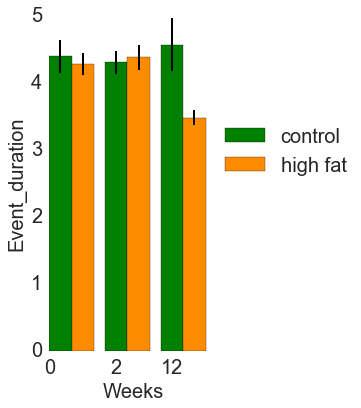

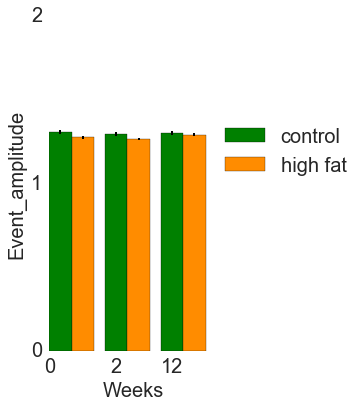

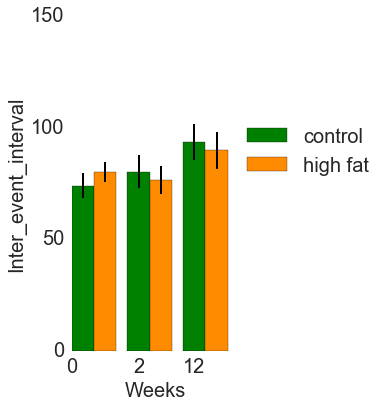

In [100]:
### find events and plot for Fig. S8a-c ###

## find events for Control group 0 weeks ##
basedir = '\\Users\\Stuber Lab\\Desktop\\Raw data\\obesity imaging\\hungry all neurons\\baseline\\Pre\\control-pre'
filename='TEST_BL_C_0wks'   #Used as prefix for files created by this program
C_0wks_dur,C_0wks_amp,C_0wks_iei,C_0wks_auc,C_0wks_count,C_0wks_max,C_0wks_min,C_0wks_std,C_0wks_mean=find_events(basedir=basedir,filename=filename)

## find events for High Fat group 0 weeks ##
basedir = '\\Users\\Stuber Lab\\Desktop\\Raw data\\obesity imaging\\hungry all neurons\\baseline\\Pre\\high fat-pre'
filename='TEST_BL_HF_0wks'   #Used as prefix for files created by this program
HF_0wks_dur,HF_0wks_amp,HF_0wks_iei,HF_0wks_auc,HF_0wks_count,HF_0wks_max,HF_0wks_min,HF_0wks_std,HF_0wks_mean=find_events(basedir=basedir,filename=filename)

## find events for Control group 2 weeks ##
basedir = '\\Users\\Stuber Lab\\Desktop\\Raw data\\obesity imaging\\hungry all neurons\\baseline\\2wks\\control 2wks'
filename='TEST_BL_C_2wks'   #Used as prefix for files created by this program
C_2wks_dur,C_2wks_amp,C_2wks_iei,C_2wks_auc,C_2wks_count,C_2wks_max,C_2wks_min,C_2wks_std,C_2wks_mean=find_events(basedir=basedir,filename=filename)

## find events for High Fat group 2 weeks ##
basedir = '\\Users\\Stuber Lab\\Desktop\\Raw data\\obesity imaging\\hungry all neurons\\baseline\\2wks\\HF 2wks'
filename='TEST_BL_HF_2wks'   #Used as prefix for files created by this program
HF_2wks_dur,HF_2wks_amp,HF_2wks_iei,HF_2wks_auc,HF_2wks_count,HF_2wks_max,HF_2wks_min,HF_2wks_std,HF_2wks_mean=find_events(basedir=basedir,filename=filename)

## find events for Control group 12 weeks ##
basedir = '\\Users\\Stuber Lab\\Desktop\\Raw data\\obesity imaging\\hungry all neurons\\baseline\\12wks\\control 12wks'
filename='TEST_BL_C_12wks'   #Used as prefix for files created by this program
C_12wks_dur,C_12wks_amp,C_12wks_iei,C_12wks_auc,C_12wks_count,C_12wks_max,C_12wks_min,C_12wks_std,C_12wks_mean=find_events(basedir=basedir,filename=filename)

## find events for High Fat group 12 weeks ##
basedir = '\\Users\\Stuber Lab\\Desktop\\Raw data\\obesity imaging\\hungry all neurons\\baseline\\12wks\\HF 12wks'
filename='TEST_BL_HF_12wks'   #Used as prefix for files created by this program
HF_12wks_dur,HF_12wks_amp,HF_12wks_iei,HF_12wks_auc,HF_12wks_count,HF_12wks_max,HF_12wks_min,HF_12wks_std,HF_12wks_mean=find_events(basedir=basedir,filename=filename)

## manually calculate means and sems to go into bar plot (Figs. S8a-c) ##
condition=['control','high fat']
def generate_bars(c1,c2,c3,hf1,hf2,hf3,label,ylim):
    means=np.nan*np.zeros((2,3))
    sem=np.nan*np.zeros((2,3))
    c1=c1[~np.isnan(c1)];c2=c2[~np.isnan(c2)];c3=c3[~np.isnan(c3)]
    hf1=hf1[~np.isnan(hf1)];hf2=hf2[~np.isnan(hf2)];hf3=hf3[~np.isnan(hf3)]
    sem[0,0]=stats.sem(c1,ddof=0)
    sem[0,1]=stats.sem(c2,ddof=0)
    sem[0,2]=stats.sem(c3,ddof=0)
    sem[1,0]=stats.sem(hf1,ddof=0)
    sem[1,1]=stats.sem(hf2,ddof=0)
    sem[1,2]=stats.sem(hf3,ddof=0)
    means[0,0]= np.nanmean(c1)
    means[0,1]= np.nanmean(c2)
    means[0,2]= np.nanmean(c3)
    means[1,0]= np.nanmean(hf1)
    means[1,1]= np.nanmean(hf2)
    means[1,2]= np.nanmean(hf3)

    ind = (0,1,2)
    ind2=(0.4,1.4,2.4)
    width = 0.4
    fig_bars,ax=plt.subplots(1,figsize=(3,6))
    plt.bar=ax.bar(ind,means[0,:],width,yerr=sem[0,:],color='g',error_kw={'ecolor':'black','linewidth':2})
    plt.bar1=ax.bar(ind2,means[1,:],width,yerr=sem[1,:],color='darkorange',error_kw={'ecolor':'black','linewidth':2})
    ax.legend((plt.bar[0],plt.bar1[1]),(condition[0],condition[1]),loc=[1,.5],fontsize=20)
    ax.set_axis_bgcolor('white')
    plt.xticks((0,1.2,2.2),(0,2,12),fontsize=20)
    plt.xlabel('Weeks',fontsize=20)
    plt.ylabel(label,fontsize=20)
    if ylim[1]-ylim[0]>100:
        plt.yticks((range(ylim[0],ylim[1]+1,50)),fontsize=20)
    else:
        plt.yticks((range(ylim[0],ylim[1]+1)),fontsize=20)
    ax.set_ylim(ylim[0],ylim[1])
    if save_figs[0]=='yes':
        fig_bars.savefig((filename+label+'_bar.png'), format='png',bbox_inches='tight')
    plt.show()
    return means,sem
    
dur_mean,dur_sem=generate_bars(C_0wks_dur,C_2wks_dur,C_12wks_dur,HF_0wks_dur,HF_2wks_dur,HF_12wks_dur,label='Event_duration',ylim=[0,5])
amp_mean,amp_sem=generate_bars(C_0wks_amp,C_2wks_amp,C_12wks_amp,HF_0wks_amp,HF_2wks_amp,HF_12wks_amp,label='Event_amplitude',ylim=[0,2])
iei_mean,iei_sem=generate_bars(C_0wks_iei,C_2wks_iei,C_12wks_iei,HF_0wks_iei,HF_2wks_iei,HF_12wks_iei,label='Inter_event_interval',ylim=[0,150])

 
TEST_BL_C_0wks_TRACKED
files = ['B5 0wks', 'G1 0wks', 'G10 0wks', 'G3 0wks']
Total ROIs = 44
Total Frames = 3000
ROIs after restriction = 44
Frames after restriction = 3000
low-pass filter = no
Number of events = 315
 
TEST_BL_HF_0wks_TRACKED
files = ['B4 0wks', 'B6 0wks', 'G5 0wks', 'G6 0wks']
Total ROIs = 33
Total Frames = 3000
ROIs after restriction = 33
Frames after restriction = 3000
low-pass filter = no
Number of events = 277
 
TEST_BL_C_2wks_TRACKED
files = ['B5 2wks', 'G1 2wks', 'G10 2wks', 'G3 2wks']
Total ROIs = 44
Total Frames = 3000
ROIs after restriction = 44
Frames after restriction = 3000
low-pass filter = no
Number of events = 265
 
TEST_BL_HF_2wks_TRACKED
files = ['B4 2wks', 'B6 2wks', 'G5 2wks', 'G6 2wks']
Total ROIs = 33
Total Frames = 3000
ROIs after restriction = 33
Frames after restriction = 3000
low-pass filter = no
Number of events = 249
 
TEST_BL_C_12wks_TRACKED
files = ['B5 12wks', 'G1 12wks', 'G10 12wks', 'G3 12wks']
Total ROIs = 44
Total Frames = 3000
ROIs

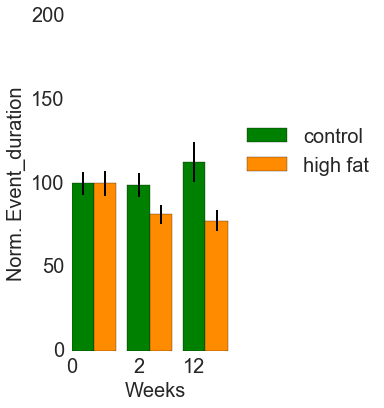

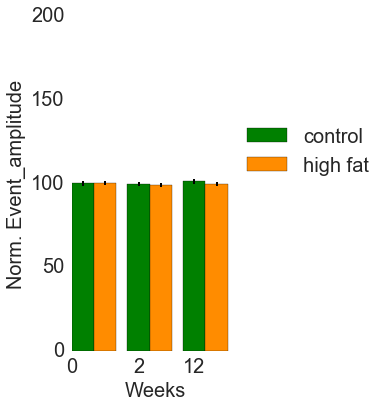

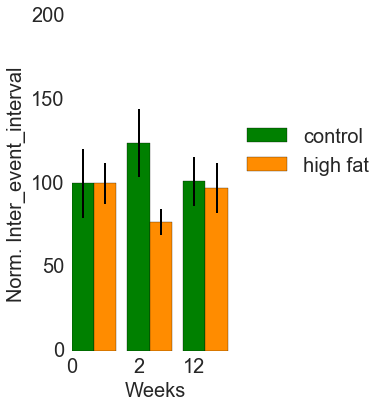

In [101]:
### find events and plot for Fig. S8h-j ###


## find events for Control group 0 weeks TRACKED ##
basedir = '\\Users\\Stuber Lab\\Desktop\\Raw data\\obesity imaging\\hungry tracked\\Baseline data\\Pre\\control-pre'
filename='TEST_BL_C_0wks_TRACKED'   #Used as prefix for files created by this program
# C_0wks_dur_tracked,C_0wks_amp_tracked,C_0wks_iei_tracked=find_events(basedir=basedir,filename=filename)
C_0wks_dur_tracked,C_0wks_amp_tracked,C_0wks_iei_tracked,C_0wks_auc_tracked,C_0wks_count_tracked,C_0wks_max_tracked, \
C_0wks_min_tracked,C_0wks_std_tracked,C_0wks_mean_tracked=find_events(basedir=basedir,filename=filename)

## find events for High Fat group 0 weeks TRACKED ##
basedir = '\\Users\\Stuber Lab\\Desktop\\Raw data\\obesity imaging\\hungry tracked\\Baseline data\\Pre\\high fat-pre'
filename='TEST_BL_HF_0wks_TRACKED'   #Used as prefix for files created by this program
HF_0wks_dur_tracked,HF_0wks_amp_tracked,HF_0wks_iei_tracked,HF_0wks_auc_tracked,HF_0wks_count_tracked,HF_0wks_max_tracked, \
HF_0wks_min_tracked,HF_0wks_std_tracked,HF_0wks_mean_tracked=find_events(basedir=basedir,filename=filename)

## find events for Control group 2 weeks TRACKED ##
basedir = '\\Users\\Stuber Lab\\Desktop\\Raw data\\obesity imaging\\hungry tracked\\Baseline data\\2wks\\control 2wks'
filename='TEST_BL_C_2wks_TRACKED'   #Used as prefix for files created by this program
C_2wks_dur_tracked,C_2wks_amp_tracked,C_2wks_iei_tracked,C_2wks_auc_tracked,C_2wks_count_tracked,C_2wks_max_tracked, \
C_2wks_min_tracked,C_2wks_std_tracked,C_2wks_mean_tracked=find_events(basedir=basedir,filename=filename)

## find events for High Fat group 2 weeks TRACKED ##
basedir = '\\Users\\Stuber Lab\\Desktop\\Raw data\\obesity imaging\\hungry tracked\\Baseline data\\2wks\\HF 2wks'
filename='TEST_BL_HF_2wks_TRACKED'   #Used as prefix for files created by this program
HF_2wks_dur_tracked,HF_2wks_amp_tracked,HF_2wks_iei_tracked,HF_2wks_auc_tracked,HF_2wks_count_tracked,HF_2wks_max_tracked, \
HF_2wks_min_tracked,HF_2wks_std_tracked,HF_2wks_mean_tracked=find_events(basedir=basedir,filename=filename)

## find events for Control group 12 weeks TRACKED ##
basedir = '\\Users\\Stuber Lab\\Desktop\\Raw data\\obesity imaging\\hungry tracked\\Baseline data\\12wks\\control 12wks'
filename='TEST_BL_C_12wks_TRACKED'   #Used as prefix for files created by this program
C_12wks_dur_tracked,C_12wks_amp_tracked,C_12wks_iei_tracked,C_12wks_auc_tracked,C_12wks_count_tracked,C_12wks_max_tracked, \
C_12wks_min_tracked,C_12wks_std_tracked,C_12wks_mean_tracked=find_events(basedir=basedir,filename=filename)

## find events for High Fat group 12 weeks TRACKED ##
basedir = '\\Users\\Stuber Lab\\Desktop\\Raw data\\obesity imaging\\hungry tracked\\Baseline data\\12wks\\HF 12wks'
filename='TEST_BL_HF_12wks_TRACKED'   #Used as prefix for files created by this program
HF_12wks_dur_tracked,HF_12wks_amp_tracked,HF_12wks_iei_tracked,HF_12wks_auc_tracked,HF_12wks_count_tracked,HF_12wks_max_tracked, \
HF_12wks_min_tracked,HF_12wks_std_tracked,HF_12wks_mean_tracked=find_events(basedir=basedir,filename=filename)

## Normalize, calculate means and sems to go into bar plot (Figs. S5d-f) ##
condition=['control','high fat']
def generate_bars_norm(c1,c2,c3,hf1,hf2,hf3,label,ylim):
    c1_norm=(c1/float(np.nanmean(c1)))*100
    c2_norm=(c2/float(np.nanmean(c1)))*100
    c3_norm=(c3/float(np.nanmean(c1)))*100
    hf1_norm=(hf1/float(np.nanmean(hf1)))*100
    hf2_norm=(hf2/float(np.nanmean(hf1)))*100
    hf3_norm=(hf3/float(np.nanmean(hf1)))*100
    means=np.nan*np.zeros((2,3))
    sem=np.nan*np.zeros((2,3))
    c1_norm=c1_norm[~np.isnan(c1_norm)]
    c2_norm=c2_norm[~np.isnan(c2_norm)]
    c3_norm=c3_norm[~np.isnan(c3_norm)]
    hf1_norm=hf1_norm[~np.isnan(hf1_norm)]
    hf2_norm=hf2_norm[~np.isnan(hf2_norm)]
    hf3_norm=hf3_norm[~np.isnan(hf3_norm)]
    sem[0,0]=stats.sem(c1_norm,ddof=0)
    sem[0,1]=stats.sem(c2_norm,ddof=0)
    sem[0,2]=stats.sem(c3_norm,ddof=0)
    sem[1,0]=stats.sem(hf1_norm,ddof=0)
    sem[1,1]=stats.sem(hf2_norm,ddof=0)
    sem[1,2]=stats.sem(hf3_norm,ddof=0)
    means[0,0]= np.nanmean(c1_norm)
    means[0,1]= np.nanmean(c2_norm)
    means[0,2]= np.nanmean(c3_norm)
    means[1,0]= np.nanmean(hf1_norm)
    means[1,1]= np.nanmean(hf2_norm)
    means[1,2]= np.nanmean(hf3_norm)

    ind = (0,1,2)
    ind2=(0.4,1.4,2.4)
    width = 0.4
    fig_bars,ax=plt.subplots(1,figsize=(3,6))
    plt.bar=ax.bar(ind,means[0,:],width,yerr=sem[0,:],color='g',error_kw={'ecolor':'black','linewidth':2})
    plt.bar1=ax.bar(ind2,means[1,:],width,yerr=sem[1,:],color='darkorange',error_kw={'ecolor':'black','linewidth':2})
    ax.legend((plt.bar[0],plt.bar1[1]),(condition[0],condition[1]),loc=[1,.5],fontsize=20)
    ax.set_axis_bgcolor('white')
    plt.xticks((0,1.2,2.2),(0,2,12),fontsize=20)
    plt.xlabel('Weeks',fontsize=20)
    plt.ylabel(label,fontsize=20)
    if ylim[1]-ylim[0]>100:
        plt.yticks((range(ylim[0],ylim[1]+1,50)),fontsize=20)
    else:
        plt.yticks((range(ylim[0],ylim[1]+1)),fontsize=20)
    ax.set_ylim(ylim[0],ylim[1])
    if save_figs[0]=='yes':
        fig_bars.savefig((filename+label+'_bar.png'), format='png',bbox_inches='tight')
    plt.show()
    return means,sem

dur_mean_tracked,dur_sem_tracked=generate_bars_norm(C_0wks_dur_tracked,C_2wks_dur_tracked,C_12wks_dur_tracked,
                                               HF_0wks_dur_tracked,HF_2wks_dur_tracked,HF_12wks_dur_tracked,
                                               label='Norm. Event_duration',ylim=[0,200])
amp_mean_tracked,amp_sem_tracked=generate_bars_norm(C_0wks_amp_tracked,C_2wks_amp_tracked,C_12wks_amp_tracked,
                                                    HF_0wks_amp_tracked,HF_2wks_amp_tracked,HF_12wks_amp_tracked,
                                                    label='Norm. Event_amplitude',ylim=[0,200])
iei_mean_tracked,iei_sem_tracked=generate_bars_norm(C_0wks_iei_tracked,C_2wks_iei_tracked,C_12wks_iei_tracked,
                                                    HF_0wks_iei_tracked,HF_2wks_iei_tracked,HF_12wks_iei_tracked,
                                                    label='Norm. Inter_event_interval',ylim=[0,200])

In [37]:
## create dataframes for SVM ##
def create_df(amp,auc,condition,dur,group,iei,maximum,mean,minimum,num,std,timepoint):
    df=pd.DataFrame()
    df['amp']=amp
    df['auc']=auc
    df['condition']=condition
    df['dur']=dur
    df['group']=group
    df['iei']=iei
    df['max']=maximum
    df['mean']=mean
    df['min']=minimum
    df['num events']=num
    df['std']=std
    df['timepoint']=timepoint
    return df

df_C0H=create_df(C_0wks_amp,C_0wks_auc,1,C_0wks_dur,0,C_0wks_iei,C_0wks_max,C_0wks_mean,C_0wks_min,C_0wks_count,C_0wks_std,0)
df_C2H=create_df(C_2wks_amp,C_2wks_auc,1,C_2wks_dur,0,C_2wks_iei,C_2wks_max,C_2wks_mean,C_2wks_min,C_2wks_count,C_2wks_std,2)
df_C12H=create_df(C_12wks_amp,C_12wks_auc,1,C_12wks_dur,0,C_12wks_iei,C_12wks_max,C_12wks_mean,C_12wks_min,C_12wks_count,C_12wks_std,12)

df_HF0H=create_df(HF_0wks_amp,HF_0wks_auc,1,HF_0wks_dur,1,HF_0wks_iei,HF_0wks_max,HF_0wks_mean,HF_0wks_min,HF_0wks_count,HF_0wks_std,0)
df_HF2H=create_df(HF_2wks_amp,HF_2wks_auc,1,HF_2wks_dur,1,HF_2wks_iei,HF_2wks_max,HF_2wks_mean,HF_2wks_min,HF_2wks_count,HF_2wks_std,2)
df_HF12H=create_df(HF_12wks_amp,HF_12wks_auc,1,HF_12wks_dur,1,HF_12wks_iei,HF_12wks_max,HF_12wks_mean,HF_12wks_min,HF_12wks_count,HF_12wks_std,12)

In [193]:
frames = [df_HF0H,df_HF2H,df_C2H,df_C12H,df_HF12H]
df=pd.concat(frames)
df=df_C0H.append(frames,ignore_index=True)
df=df.dropna(axis=0)
df_norm=df

In [195]:
## if you want to restrict analysis to specific timepoint use this##
df_norm=df_norm[((df_norm['timepoint']==0) & (df_norm['condition']==1))]#condition=1=hungry
predict_outcome='group'  #which parameter do you want to predict (values should be 0 or 1)
svm_filename='BL_0wks_pred_group'
timepoint=0

('prediction accuracy = ', 0.54515050167224077)
('shuffled accuracy = ', 0.60200668896321075)
0
('prediction accuracy = ', 0.55290102389078499)
('shuffled accuracy = ', 0.50511945392491464)
1
('prediction accuracy = ', 0.5374149659863946)
('shuffled accuracy = ', 0.56122448979591832)
2
('prediction accuracy = ', 0.55704697986577179)
('shuffled accuracy = ', 0.5436241610738255)
3
('prediction accuracy = ', 0.55000000000000004)
('shuffled accuracy = ', 0.53666666666666663)
4
('prediction accuracy = ', 0.54515050167224077)
('shuffled accuracy = ', 0.57190635451505012)
5
('prediction accuracy = ', 0.54761904761904767)
('shuffled accuracy = ', 0.55782312925170063)
6
('prediction accuracy = ', 0.56478405315614622)
('shuffled accuracy = ', 0.50498338870431891)
7
('prediction accuracy = ', 0.5547945205479452)
('shuffled accuracy = ', 0.53424657534246578)
8
('prediction accuracy = ', 0.59655172413793101)
('shuffled accuracy = ', 0.50689655172413794)
9
('prediction accuracy = ', 0.55254237288135

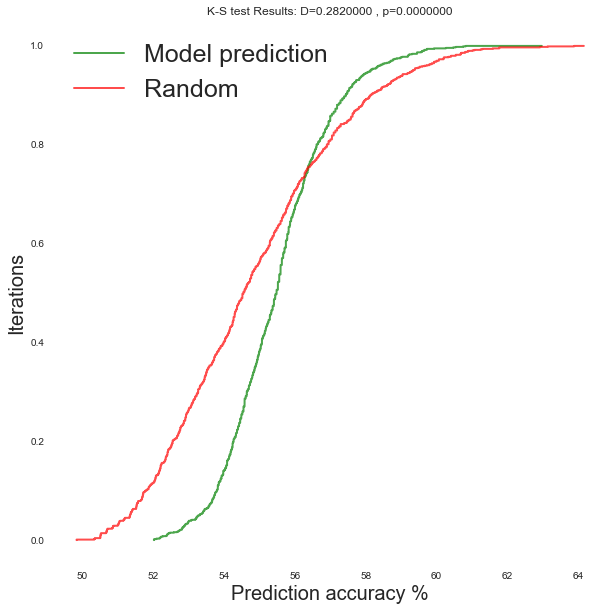

In [197]:
##Use SVM to classify data based on 'group'
iterations=1000
test_data=.1  #defines split for test/train sets
parameters = [{'C': [0.001, .01,.1,1,10,100,1000], 'gamma': [0.001, .01,.1,1,10,100,1000], 'kernel': ['rbf']}]

pred_score=np.nan*np.zeros((iterations))
rand_score=np.nan*np.zeros((iterations))
for i in range(iterations):
    clf = GridSearchCV(SVC(), parameters,cv=10)#,verbose=1000)
    msk = np.random.rand(len(df_norm))>test_data
    train = df_norm[msk]
    train_labels=train[[predict_outcome]].values
    c,r=train_labels.shape
    train_labels=train_labels.reshape(c,)
    clf.fit(train[['amp','auc','dur','iei','num events','min','max','mean']], train_labels)
    print ('prediction accuracy = ', clf.best_score_)
    pred_score[i]=(clf.best_score_)*100

    ##random array of 1s and 0s for shuffled classifier
    rand_group=pd.DataFrame(np.random.randint(2,size=train.shape[0]))
    clf.fit(train[['amp','auc','dur','iei','num events','min','max','mean']], rand_group[0])
    print ('shuffled accuracy = ', clf.best_score_)
    rand_score[i]=(clf.best_score_)*100
    print i

d,p=stats.ks_2samp(pred_score,rand_score)
plt.figure(figsize=(10,10))
ax=plt.subplot(111)
n = np.arange(1,len(pred_score)+1) / np.float(len(pred_score))
Xs = np.sort(pred_score)
plt.step(Xs,n,color='g',label='Model prediction',alpha=0.7,linewidth=2)
n2= np.arange(1,len(rand_score)+1) / np.float(len(rand_score))
Xs2= np.sort(rand_score)
plt.step(Xs2,n,color='r',label='Random',alpha=0.7,linewidth=2)
ax.set_axis_bgcolor('white')
plt.xlabel('Prediction accuracy %',fontsize=20)
plt.ylabel('Iterations',fontsize=20)
plt.title('K-S test Results: '+str("D={0:.7f}".format(round(d,3)))+' , '+str("p={0:.7f}".format(round(p,3))),fontsize=12)
plt.legend(fontsize=25,loc=2)
plt.savefig(svm_filename+str(iterations)+str('iter_')+str(test_data)+str(timepoint)+'wks_test_data_prediction_accuracy_hist.png')
np.savetxt(svm_filename+str(iterations)+str('iter_')+str(test_data)+str(timepoint)+'wks_test_data_prediction_accuracy.csv',pred_score,delimiter=',')
np.savetxt(svm_filename+str(iterations)+str('iter_')+str(test_data)+str(timepoint)+'wks_test_data_RANDOM_prediction_accuracy.csv',rand_score,delimiter=',')
plt.show()